In [7]:
from mpmath import mp
import numpy as np

In [46]:
import glworia.load_interp
from glworia.load_interp import *

In [87]:
mp.dps = 30

In [243]:
def SIS_term(n, w, y):
    term_1 = mp.gamma(1 + n/2)/mp.fac(n)
    term_2 = (2*w*mp.exp(3j*mp.pi/2))**(n/2)
    term_3 = mp.hyp1f1(1 + n/2, 1, -1j/2*w*y**2)
    return term_1*term_2*term_3

def SIS_sum(N, w, y):
    sum = 0
    for n in range(N):
        sum += SIS_term(n, w, y)
    return mp.exp(1j/2*w*y**2 + (0.5 + y)*1j*w)*sum

SIS_sum_vec = np.vectorize(SIS_sum, excluded=['N', 'y'])

In [244]:
from importlib import reload

In [245]:
reload(glworia.load_interp)
from glworia.load_interp import *

In [246]:
import matplotlib.pyplot as plt

In [247]:
lp_name = 'x_c'

settings = {
    'lens_param_name': lp_name,
    'y_low': 0.1,
    'y_high': 5.0,
    lp_name + '_low': 0.,
    lp_name + '_high': 1.,
    'N_grid': 31,
    'N_grid_strong': 61,
    'N_crit': 61,
    'N': 200,
    'lens_model_name': 'CIS',

    'T0_max': 1000,

    'y_low_im': 0.1,
    'y_high_im': 5.0,
    lp_name + '_low_im': 0.,
    lp_name + '_high_im': 1.,
    'N_grid_im': 201,
    'N_crit_im': 201,
}

In [248]:
# def strong_lens_cond_override_gSIS(strongly_lensed, y_interp, kappa_interp):
#     if np.abs(kappa_interp - 1.) < 1e-15:
#         if y_interp < 1.:
#             strongly_lensed = True
#         else:
#             strongly_lensed = False
#     return strongly_lensed

In [249]:
interpolators = load_interpolators('./interpolation', **settings)

In [250]:
w_interp = np.linspace(0.01, 1e3, 10**5)

In [251]:
y_interp = 0.2
lp_interp = 0.

In [252]:
F, F_g, partitions, T_im, mu_im, u0, u1, u2, u3, um, w1, F1, w2, F2 = F_interp(w_interp, y_interp, lp_interp, interpolators, settings,
             return_geom = True, 
             )

/home/markc/glworia/glworia/glworia/load_interp.py:210: RuntimeWarning: divide by zero encountered in divide
  return (1 + np.tanh((x - x0)/a))/2


In [253]:
T_im

[array(0.4), array(0.7200225), 0]

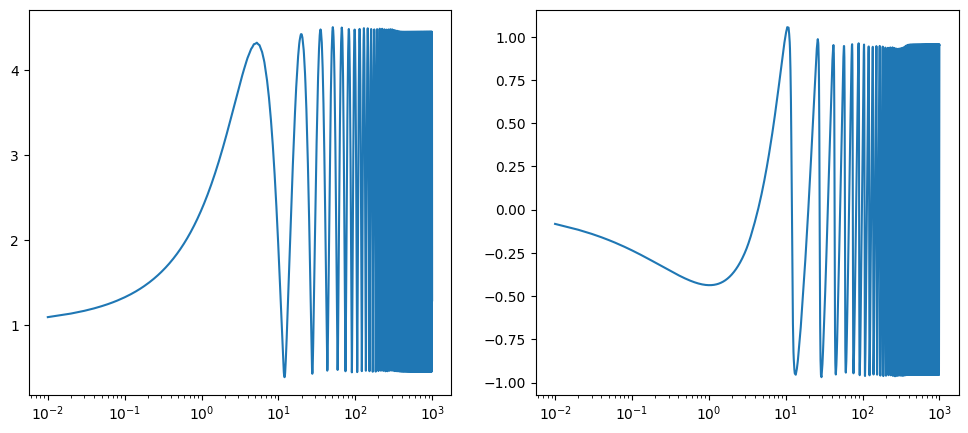

In [254]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].semilogx(w_interp, np.abs(F))
# axs[0].semilogx(w_interp, np.abs(F_g), alpha = 0.5)
axs[1].semilogx(w_interp, np.angle(F))

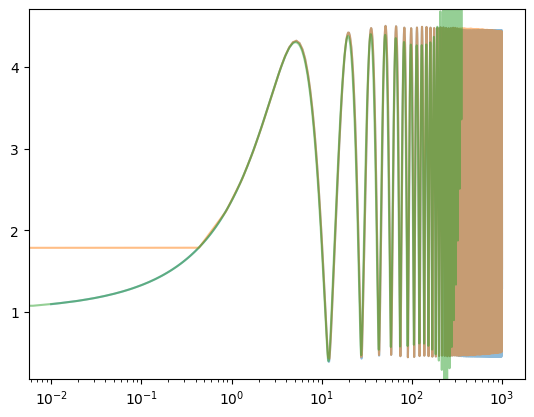

In [255]:
# cut at 1e3

F1_cut = F1[w1 < 1e3]
w1_cut = w1[w1 < 1e3]
F2_cut = F2[w2 < 1e3]
w2_cut = w2[w2 < 1e3]

plt.semilogx(w_interp, np.abs(F), alpha = 0.5)
plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())

plt.semilogx(w1_cut, np.abs(F1_cut), alpha = 0.5)
plt.semilogx(w2_cut, np.abs(F2_cut), alpha = 0.5)

In [256]:
ws = np.logspace(-1, 2, 1000)
Fs = SIS_sum_vec(300, ws, 0.2)
Fs = np.array(Fs.tolist(), dtype=np.complex128)

In [257]:
import matplotlib.pyplot as plt

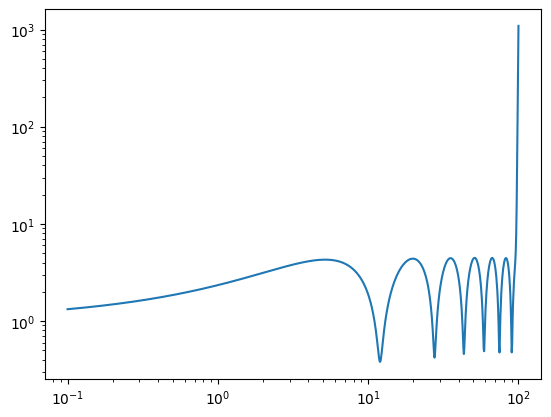

In [258]:
plt.loglog(ws, np.abs(Fs))

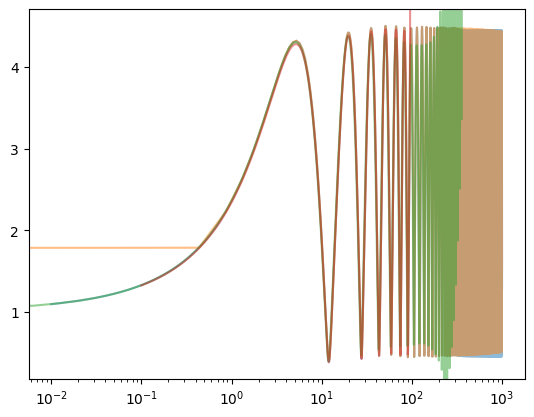

In [259]:
F1_cut = F1[w1 < 1e3]
w1_cut = w1[w1 < 1e3]
F2_cut = F2[w2 < 1e3]
w2_cut = w2[w2 < 1e3]

plt.semilogx(w_interp, np.abs(F), alpha = 0.5)
plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())

plt.semilogx(w1_cut, np.abs(F1_cut), alpha = 0.5)
plt.semilogx(w2_cut, np.abs(F2_cut), alpha = 0.5)
plt.semilogx(ws, np.abs(Fs), alpha = 0.5)

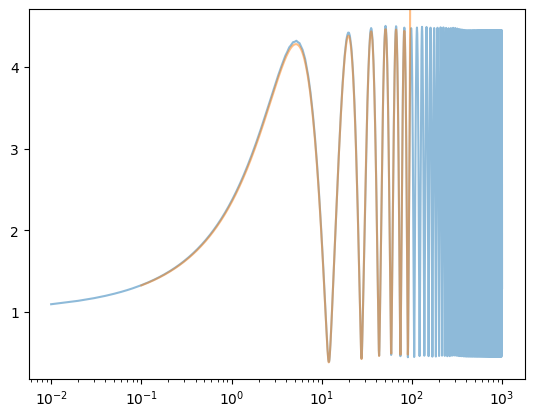

In [260]:
plt.semilogx(w_interp, np.abs(F), alpha = 0.5)
plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())
plt.semilogx(ws, np.abs(Fs), alpha = 0.5)

In [261]:
from scipy.interpolate import interp1d

F_interp_func = interp1d(w_interp, F, kind = 'cubic', bounds_error = False, fill_value = 0.)

F_interp_2 = F_interp_func(ws)


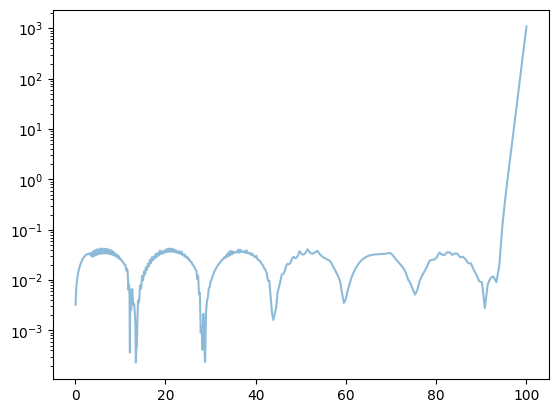

In [262]:
plt.semilogy(ws, np.abs(np.abs(F_interp_2) - np.abs(Fs)), alpha = 0.5)

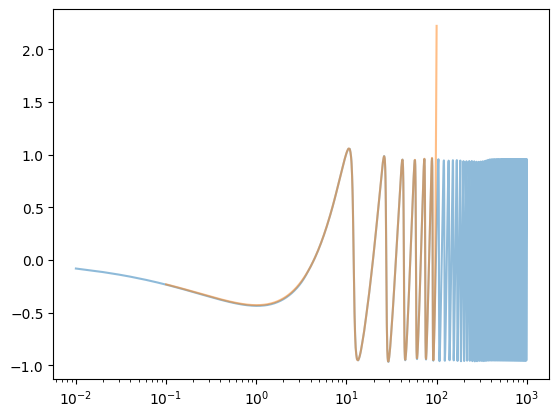

In [263]:
plt.semilogx(w_interp, np.unwrap(np.angle(F)), alpha = 0.5)
# plt.xlim(*plt.xlim())
# plt.ylim(*plt.ylim())
plt.semilogx(ws, np.unwrap(np.angle(Fs)), alpha = 0.5)
# plt.semilogx(ws, -ws/2)
# plt.semilogx(ws, -ws)